In [50]:
import os
from os.path import expanduser
import socket
import sys
import glob

# BELOW IS SYSTEM/PATH CONFIGURATION #
my_home = expanduser("~")
running_system = socket.gethostname()
# Configure machine's names here #
systemHLRN = 'blogin1'
systemLOCAL = 'Laurents-MacBook-Pro.local'
my_home = expanduser("~")
# Define local pass #
wd_path = '/home/hbkoziel/pyfesom/'
save_path = wd_path+'/figures/Arc12/FINAL/'

#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')
#########################################

In [51]:
import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

import xarray as xr
import pandas as pd
sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

In [52]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/home/hbkoziel/pyfesom/data/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'VNF'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'

/home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh


In [117]:
print('loading index...')
df = pd.read_csv('/home/hbkoziel/awi-models/data/mesh/meshArc4.5/bioregion_index_latlon.csv', delimiter=',',header=0)
print('LOADING DONE')
df.sort_values(by ='Unique_ID',inplace=True)
index = df["Unique_ID"]
index_unique = df.Unique_ID.unique().tolist()
index_unique.pop(-1)
print('SORTING...')
names = df.Name.unique().tolist()
names.pop(-1)
names[3]='Beaufort Sea - shelf'
names[4]='Amundsen-Viscount'
names.append('All Arctic Ocean (>66N)')
print('CLEANING DONE...')
ind_bio = df.full_index[df.Unique_ID == 24]

loading index...
LOADING DONE
SORTING...
CLEANING DONE...


In [62]:
ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
f           = Dataset(ncfile, 'r')
NodalAreaModel = f.variables['cluster_area'][:]

In [99]:
ind_yerm = (np.array(mesh.x2>-10) & np.array(mesh.x2<10) & np.array(mesh.y2>80) & np.array(mesh.y2<85))

In [113]:
tracername = 'cur50m'
time = pd.date_range('1985-01-01', freq="MS", periods= 12*len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = time

CUR_sel = data.cur50m.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
CUR_sel = CUR_sel.compute()

# CUR_march = CUR_sel[data['time.month']==3]
# CUR_march = CUR_march.compute()

CUR_yrly = CUR_sel.resample(time = 'Y').mean(dim = 'time')
CUR_yrly = CUR_yrly.compute()

#ind_curr = np.array(CUR_sept_mean >= 0.03)

# pf = np.polyfit(years, CUR_sept, 1)
# CUR_trend = pf[0]

In [208]:
tracername = 'VNF'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
dates = pd.date_range('1985', freq="MS", periods= 12*len(np.arange(1985,2016,1)))
#time = pd.date_range('1985-01-01', freq="MS", periods= 12*len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = dates
ANPP_sel = data.VNF.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
ANPP_sel = ANPP_sel.compute()
# EKE_sept_mean = EKE_sept.mean(dim='time')
# EKE_sept_mean = EKE_sept_mean.compute()
ANPP_yrly = ANPP_sel.resample(time = 'Y').mean(dim = 'time')
ANPP_yrly = ANPP_yrly.compute()
#ANPP_yrly.where(CUR_yrly<=0.8, np.nan)
ANPP_yrly1 = ANPP_yrly.where(CUR_yrly >= 0.03) 
ANPP_yrly2 = ANPP_yrly.where(CUR_yrly <= 0.03)
# pf = np.polyfit(years, ANPP_yrly, 1)
# ANPP_trend1 = pf[0]

# ts_yerm1  = np.sum(ANPP_yrly1[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])
# ts_yerm2  = np.sum(ANPP_yrly2[:,ind_bio]*NodalAreaModel[ind_bio],axis=1)/np.sum(NodalAreaModel[ind_bio])

ts_yerm1  = np.nanmean(ANPP_yrly1[:,ind_bio],axis=1)/np.nanstd(ANPP_yrly1[:,ind_bio],axis=1)
ts_yerm2  = np.nanmean(ANPP_yrly2[:,ind_bio],axis=1)/np.nanstd(ANPP_yrly2[:,ind_bio],axis=1)

#ts_yerm = ts_yerm / np.std(ANPP_yrly[:,ind_curr])
pf1 = np.polyfit(years, ts_yerm1, 1)
ANPP_trend31 = pf1[0]
pf2 = np.polyfit(years, ts_yerm2, 1)
ANPP_trend32 = pf2[0]

In [217]:
plt.hexbin(ANPP_yrly1[:,ind_bio], gridsize=50)

TypeError: hexbin() takes at least 2 arguments (2 given)

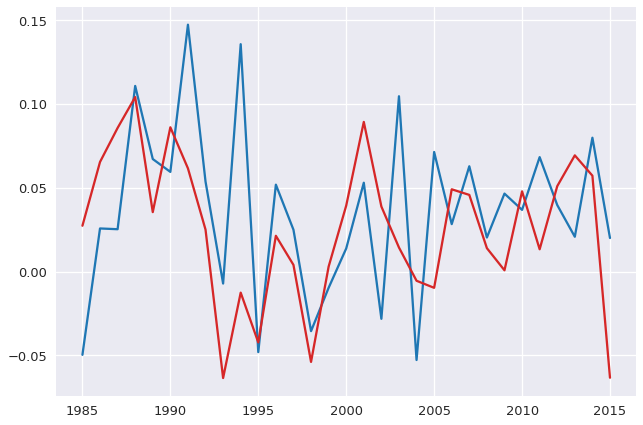

In [209]:
plt.style.use('seaborn')
plt.style.use('seaborn-talk')
plt.plot(years,ts_yerm2, color = 'tab:blue')
plt.plot(years,ts_yerm1, color = 'tab:red')

In [194]:
first_year = 1993
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
dates = pd.date_range('1985', freq="MS", periods= 12*len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = dates
ANPP_sel = data.VNF.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
ANPP_sel = ANPP_sel.compute()
ANPP_yrly = ANPP_sel.resample(time = 'YS').mean(dim = 'time')
ANPP_yrly = ANPP_yrly.compute()
pf = np.polyfit(years, ANPP_yrly, 1)
ANPP_trend2 = pf[0]

In [195]:
ind_fram = (np.array(np.abs(mesh.x2)<90) & np.array(mesh.y2<80))
ANPP_trend1[ind_fram]=np.nan
ANPP_trend2[ind_fram]=np.nan
ANPP_trend1[ANPP_trend1==0]=np.nan
ANPP_trend2[ANPP_trend2==0]=np.nan

In [196]:
import pyfesom as pf

data1, elem_no_nan1 = pf.get_data(ANPP_trend1,mesh,0)
data2, elem_no_nan2 = pf.get_data(ANPP_trend2,mesh,0)

For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used


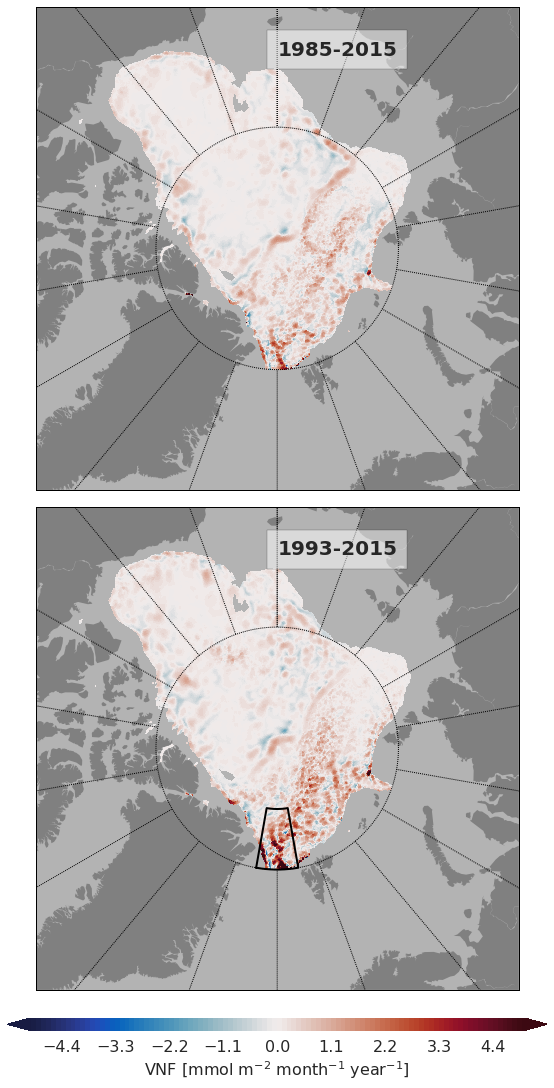

In [197]:
#fig = plt.figure()
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(15, 15), facecolor='w', edgecolor='k')

plt.subplot(axs[0])
#axs[0]      = fig.add_subplot(211)
contours = np.arange(-5, 5.1, .1)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps
im=axs[0].tricontourf(x, y, elem_no_nan1, data1, levels=contours, cmap=cmap.cm.balance, extend='both')
axs[0].annotate('1985-2015', xy=(0.6, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

#axs[1]      = fig.add_subplot(212)
plt.subplot(axs[1])
contours = np.arange(-5, 5.1, .1)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps
im2=axs[1].tricontourf(x, y, elem_no_nan2, data2, levels=contours, cmap=cmap.cm.balance, extend='both')
axs[1].annotate('1993-2015', xy=(0.6, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
label = 'VNF [mmol m$^{-2}$ month$^{-1}$ year$^{-1}$]'
#plt.title(year)

# subplot for colorbar
cbar = fig.colorbar(im, ax=axs[:1], shrink=0.5, location='bottom')
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label, fontsize=16)


lat_1 = 80
lat_2 = 85
lon_1 = -10
lon_2 = 10

lati = np.append(np.linspace(lat_1,lat_2,10),np.ones(10)*lat_2)
lati = np.append(lati,np.linspace(lat_2,lat_1,10))
lati = np.append(lati,np.ones(10)*lat_1)

loni = np.append(np.ones(10)*lon_1,np.linspace(lon_1,lon_2,10))
loni = np.append(loni,np.ones(10)*lon_2)
loni = np.append(loni,np.linspace(lon_2,lon_1,10))

xi, yi = m(loni, lati)
axs[1].plot(xi,yi,'k',lw=2)


#plt.savefig(save_path+'FIG9.png', dpi = 300, bbox_inches='tight') 

In [212]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):

    # Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    # Thus the input data could be a 1D time series, or for example, have three 
    # dimensions (time,lat,lon). 
    # Datasets can be provided in any order, but note that the regression slope 
    # and intercept will be calculated for y with respect to x.
    # Output: Covariance, correlation, regression slope and intercept, p-value, 
    # and standard error on regression between the two datasets along their 
    # aligned time dimension.  
    # Lag values can be assigned to either of the data, with lagx shifting x, and
    # lagy shifting y, with the specified lag amount. 

    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:

        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')

        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='time')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats

    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr